In [1]:
import csv
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

2022-02-16 15:05:11.474893: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2022-02-16 15:05:11.474923: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Specify each path

In [2]:
# Specify data paths
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
# Change training classes if necessary
NUM_CLASSES = 10

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([1595, 1663, 1510,  672,  164,  257,  139,  190,  144,  130]))


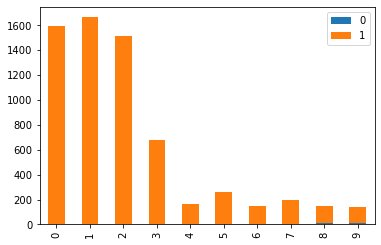

In [7]:
# Classes count
counts = np.unique(y_dataset, return_counts=True)
df = pd.DataFrame(counts)
df.T.plot(kind="bar", stacked=True)
print(counts)

# Model building

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

2022-02-16 15:05:14.347381: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-16 15:05:14.381677: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-16 15:05:14.381708: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (G3): /proc/driver/nvidia/version does not exist
2022-02-16 15:05:14.382130: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-16 15:05:14.391581: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz
2022-02-16 15:05:14.391907: I tensorflow/compi

In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 42)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1

In [10]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=50, verbose=1)

In [11]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

2022-02-16 15:05:14.648478: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/1000
76/76 [==============================] - 1s 9ms/step - loss: 2.0873 - accuracy: 0.2181 - val_loss: 1.5308 - val_accuracy: 0.4691

Epoch 00001: val_loss improved from inf to 1.53084, saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 2/1000
76/76 [==============================] - 0s 3ms/step - loss: 1.3849 - accuracy: 0.5304 - val_loss: 0.9452 - val_accuracy: 0.6974

Epoch 00002: val_loss improved from 1.53084 to 0.94521, saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 3/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.8210 - accuracy: 0.7415 - val_loss: 0.6020 - val_accuracy: 0.8311

Epoch 00003: val_loss improved from 0.94521 to 0.60199, saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 4/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.5243 - accuracy: 0.8483 - val_loss: 0.4261 - val_accuracy: 0.8868

Epoch 00004: val_loss improved from 0.60199 to 0.42612, saving 

In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Model evaluation
# TODO Test on loaded model
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=64)

26/26 [==============================] - 0s 1ms/step - loss: 0.0207 - accuracy: 0.9969


In [15]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[1.4425133e-06 9.9999404e-01 1.3344758e-06 1.0386054e-13 1.1154550e-07
 2.2041430e-14 4.4938588e-08 6.8326506e-15 1.1061885e-21 2.9228381e-06]
1


# Confusion matrix

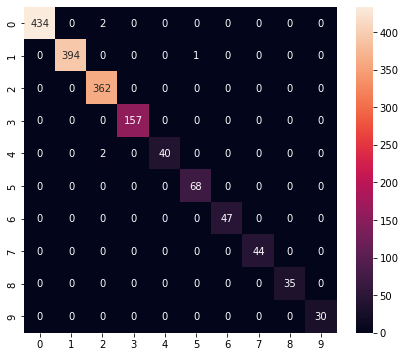

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       436
           1       1.00      1.00      1.00       395
           2       0.99      1.00      0.99       362
           3       1.00      1.00      1.00       157
           4       1.00      0.95      0.98        42
           5       0.99      1.00      0.99        68
           6       1.00      1.00      1.00        47
           7       1.00      1.00      1.00        44
           8       1.00      1.00      1.00        35
           9       1.00      1.00      1.00        30

    accuracy                           1.00      1616
   macro avg       1.00      0.99      1.00      1616
weighted avg       1.00      1.00      1.00      1616



In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [17]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [18]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

2022-02-16 15:05:45.542415: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpccim461k/assets


2022-02-16 15:05:46.374460: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2022-02-16 15:05:46.374599: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-02-16 15:05:46.376204: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.002ms.
  function_optimizer: function_optimizer did nothing. time = 0ms.

2022-02-16 15:05:46.422885: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2022-02-16 15:05:46.422922: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.
2022-02-16 15:05:46.439626: I tensorflow/lite/tools/optimize/quantize_weights.cc:222] Skipping quantization of tensor sequential/dense_2/MatMul because it has fewer than 1024 elements (512).
2022-02-16 15:05:

7840

## Inference test

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [20]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 85 µs, sys: 6 µs, total: 91 µs
Wall time: 128 µs


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.7303367e-06 9.9998868e-01 1.6084380e-06 2.3611194e-13 1.9235351e-07
 2.5984638e-14 6.9619794e-08 9.1038932e-15 1.5372887e-21 6.6452908e-06]
1


## Download model

In [24]:
!zip -r model.zip keypoint_classifier  

	zip warning: name not matched: keypoint_classifier

zip error: Nothing to do! (try: zip -r model.zip . -i keypoint_classifier)




---


# ❗️Hyperparameters Tuning

In [25]:
%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp

In [26]:
# Init parameters to tune
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16, 32, 64]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([8, 16, 32]))
HP_NUM_UNITS_3 = hp.HParam('num_units_3', hp.Discrete([8, 16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.0, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

In [27]:
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS_1,HP_NUM_UNITS_2,HP_NUM_UNITS_3, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [28]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=15, verbose=1)

In [29]:
def train_test_model(hparams):

  model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_1], activation='relu'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_2], activation='relu'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_3], activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
  
  model.compile(
    optimizer=hparams[HP_OPTIMIZER],
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
  
  cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)

  model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[
               cp_callback,
               es_callback,
               ]
  ) 

  # Load model with best accuracy
  model = tf.keras.models.load_model(model_save_path)

  _, accuracy = model.evaluate(X_test, y_test)
  return accuracy

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
session_num = 0

for num_units_1 in HP_NUM_UNITS_1.domain.values:
  for num_units_2 in HP_NUM_UNITS_2.domain.values:
    for num_units_3 in HP_NUM_UNITS_3.domain.values:
      for dropout_rate in np.arange(HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value, 0.1):
        for optimizer in HP_OPTIMIZER.domain.values:
          hparams = {
              HP_NUM_UNITS_1: num_units_1,
              HP_NUM_UNITS_2: num_units_2,
              HP_NUM_UNITS_3: num_units_3,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
          }
          run_name = "run-%d" % session_num
          #print('--- Starting trial: %s' % run_name)
#          print({h.name: hparams[h] for h in hparams})
          run('logs/hparam_tuning/' + run_name, hparams)
          session_num += 1

--- Starting trial: run-0
Epoch 1/50
76/76 [==============================] - 1s 5ms/step - loss: 2.0237 - accuracy: 0.2462 - val_loss: 1.6756 - val_accuracy: 0.3670

Epoch 00001: val_loss improved from inf to 1.67564, saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 2/50
76/76 [==============================] - 0s 3ms/step - loss: 1.5967 - accuracy: 0.4165 - val_loss: 1.3938 - val_accuracy: 0.5910

Epoch 00002: val_loss improved from 1.67564 to 1.39383, saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 3/50
76/76 [==============================] - 0s 3ms/step - loss: 1.2822 - accuracy: 0.6084 - val_loss: 1.1236 - val_accuracy: 0.6788

Epoch 00003: val_loss improved from 1.39383 to 1.12365, saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 4/50
76/76 [==============================] - 0s 3ms/step - loss: 1.0412 - accuracy: 0.6923 - val_loss: 0.9110 - val_accuracy: 0.7172

Epoch 00004: val_loss improved from 1.12365 t

In [ ]:
# !ATTENTION! Works only in Colab
%tensorboard --logdir logs/hparam_tuning

In [ ]:
!rm -rf logs